# UNet Implementation from Scratch using PyTorch.
Paper: U-Net: Convolutional Networks for Biomedical Image Segmentation

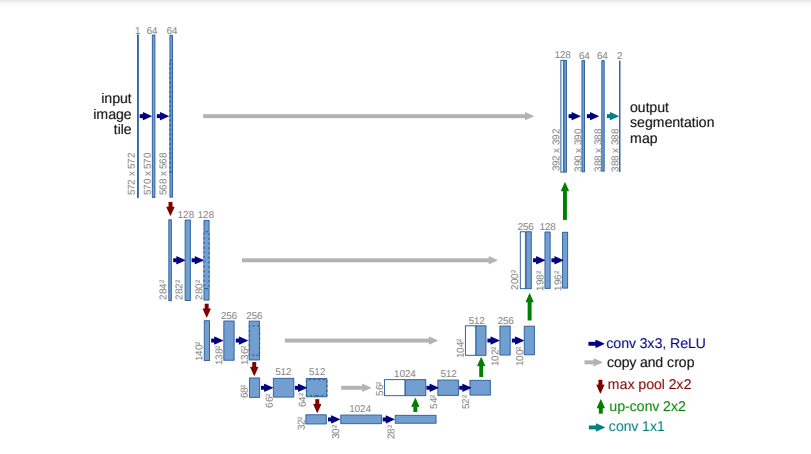

## U-Net Model

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

    
class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.down_layer = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias = False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias = False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, X):
        return self.down_layer(X)
    
class BottleNeck(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(BottleNeck, self).__init__()
        self.down_layer = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, X):
        return self.down_layer(X)
    
class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Up, self).__init__()
        # eg in_channels = 1024, out_channels = 512
        # 1024 in_channels from prev layer
        '''
        In ConvTrans : 1024 --> 512
        through skip_connection's 512 : 512 + 512 = 1024 (which is equal to in_channels)
        So input of DoubleConv is also in_channels
        In DoubleConv:
            Conv2D: 1024 --> 512
            Conv2D:  512 --> 512
        
        In ConvTrans : N --> N/2
        through skip_connection's N/2 : N/2 + N/2 = N (which is equal to in_channels)
        So input of DoubleConv is also in_channels
        In DoubleConv:
            Conv2D: N   --> N/2
            Conv2D: N/2 --> N/2
        for next layer, it will go from N/2 --> N/4
        '''
        self.up_conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2) # 1024 --> 512
        self.DoubleConv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias = False),  # 1024 --> 512
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias = False), # 1024 --> 512
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, X, skip_connection):
        X1 = self.up_conv(X)
        if(X1.shape != skip_connection.shape):
            X1 = TF.resize(X1, skip_connection.shape[2:]) # X1 height and width might not remain still same if max_pooling floors the dimension, so match it with the skip_connection height and width
                
        X2 = torch.cat((X1, skip_connection), dim=1) # concatenate skip_connection along channel dimension
        
        return self.DoubleConv(X2)

class FinalConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(FinalConv, self).__init__()
        self.finalConv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1)
        # kernel size = 1, since the height and width of the final layer and this should be same(given in paper)
        
    def forward(self, X):
        return self.finalConv(X)
    
class UNet(nn.Module):
    def __init__(self, in_channels = 3, out_channels = 1):
        super(UNet, self).__init__()
        self.max_pool = nn.MaxPool2d(2, 2)
        self.down1 = Down(in_channels, 64)
        self.down2 = Down(64, 128)
        self.down3 = Down(128, 256)
        self.down4 = Down(256, 512)
        
        self.bottleNeck = Down(512, 1024) 
        
        self.up1 = Up(1024, 512)
        self.up2 = Up(512, 256)
        self.up3 = Up(256, 128)
        self.up4 = Up(128, 64)
        
        self.finalConv = FinalConv(64, out_channels)
        
        
    def forward(self, X):
        
        ''' DownSampling '''             # Channels
        x1_skip = self.down1(X)          # 003-->064
        x1 = self.max_pool(x1_skip)
        
        x2_skip = self.down2(x1)         # 064->128
        x2 = self.max_pool(x2_skip)
        
        x3_skip = self.down3(x2)         # 128-->256
        x3 = self.max_pool(x3_skip)
        
        x4_skip = self.down4(x3)         # 256-->512
        x4 = self.max_pool(x4_skip)
        
        
        ''' BottleNeck Layer '''
        x5 = self.bottleNeck(x4)         # 512-->1024
        
        
        ''' UpSampling '''       
        x  = self.up1(x5, x4_skip)       # [x5(1024, up_conv will take it to 512) + x4(512)] --> 512
        
        x  = self.up2(x , x3_skip)       # [x ( 512, up_conv will take it to 256) + x3(256)] --> 256
        
        x  = self.up3(x , x2_skip)       # [x ( 256, up_conv will take it to 128) + x2(128)] --> 128
        
        x  = self.up4(x , x1_skip)       # [x ( 128, up_conv will take it to  64) + x1( 64)] --> 64
        
        x  = self.finalConv(x)           # 64 --> 01
        
        return x

## Dataset creation
* The dataset used is the Carvana Image Segmentation Dataset, which has images of cars and corresponding binary masks.
* Using Albumentations library to perform data augmentation on the images, thereby increasing the dataset size and helping the model learn more general features.

In [2]:
import os
from PIL import Image
import pathlib

from torch.utils.data import Dataset
import numpy as np

class CarvanaDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform = None):
        super().__init__()
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)
        self.masks = os.listdir(mask_dir)
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, key: int):
        image_path = os.path.join(self.image_dir, self.images[key])
        mask_path = os.path.join(self.mask_dir, self.images[key].replace(".jpg", "_mask.gif"))
        image = np.array(Image.open(image_path).convert("RGB")) # we are using np array since we will be using Albumentations library which requires the input to be in np.array
        mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)
        mask[mask == 255.0] = 1.0
        
        if self.transform:
            augmentations = self.transform(image = image, mask = mask)
            image = augmentations["image"]
            mask = augmentations["mask"]
        return image, mask

### Plotting few examples from the Training Dataset

`show_images_masks` - Plots Images, masks and corresponding predictions(if present)

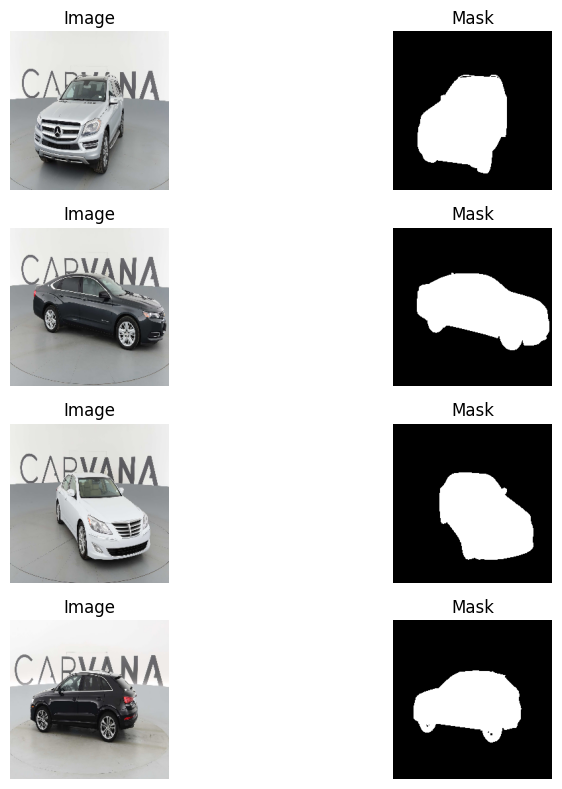

In [17]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Instantiate the dataset
image_dir = '/kaggle/input/unetfolder/U_Net/data/train'
mask_dir = '/kaggle/input/unetfolder/U_Net/data/train_masks'

IMAGE_HEIGHT, IMAGE_WIDTH = 240, 240
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

transform = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std = [1.0, 1.0, 1.0],
            max_pixel_value=255.0
        ),
        ToTensorV2()
    ]
)
dataset = CarvanaDataset(image_dir=image_dir, mask_dir=mask_dir, transform=transform)

# Create a DataLoader
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Function to display images and masks
def show_images_masks(images, masks, model= None, predict=False, num_examples=4, device = DEVICE):
    columns = 3 if(predict==True) else 2
    fig, axes = plt.subplots(num_examples, columns, figsize=(10, 8))
    for i in range(num_examples):
        # Display image
        
        image = images[i].numpy().transpose(1, 2, 0)
        mask = masks[i].numpy()
        
        axes[i, 0].imshow(image)
        axes[i, 0].set_title('Image')
        axes[i, 0].axis('off')

        # Display mask
        axes[i, 1].imshow(mask, cmap='gray')
        axes[i, 1].set_title('Mask')
        axes[i, 1].axis('off')
        
        if(predict!=False):
            model.eval()
            with torch.inference_mode():
                X, y = images.to(DEVICE), masks.to(DEVICE)
                preds = torch.sigmoid(model(X))
                preds = (preds > 0.5).float()
                
            pred = preds[i].squeeze().cpu().numpy()
            # Display predicted mask
            axes[i, 2].imshow(pred, cmap='gray')
            axes[i, 2].set_title('Predicted Mask')
            axes[i, 2].axis('off')
            
                
    plt.tight_layout()
    plt.show()

# Get a batch of data
images, masks = next(iter(dataloader))

# Plot the images and masks
show_images_masks(images, masks, num_examples=4)


## Utility functions
1. `get_loaders` - returns train_dataloader and test_dataloaders
2. `eval_model` - evaluates the model performance on 2 metrics 

a. `Accuracy` - Measures number of correctly classified pixels over all pixels.
                But, as most of the pixels are black rather than white, meaning accuracy will be biased towards black pixels.
                
b. `Dice Score` - A statistical measure used to find the similarity between two sets. In the context of image segmentation, it evaluates the overlap between the predicted segmentation mask and the ground truth mask. It is defined as:
                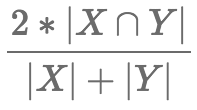
                where `X` is the set of pixels in the predicted mask, and `Y` is the set of pixels in the ground truth mask. The Dice Score ranges from 0 to 1, where 0 indicates no overlap and 1 indicates perfect overlap.
                
3. `save_predictions` - will save few predictions as images after the completion of training.

In [6]:
import torch
from torch.utils.data import DataLoader
import torchvision

def get_loaders(
    train_dir,
    train_maskdir,
    val_dir, 
    val_maskdir,
    train_transform,
    val_transform,
    batch_size,
    num_workers,
    pin_memory = True
):
    train_data = CarvanaDataset(image_dir=train_dir,
                                mask_dir=train_maskdir, 
                                transform=train_transform)
    val_data = CarvanaDataset(image_dir=val_dir, 
                                mask_dir=val_maskdir, 
                                transform=val_transform)
    
    train_dataloader = DataLoader(dataset=train_data,
                                batch_size=batch_size,
                                shuffle=True,
                                num_workers=num_workers,
                                pin_memory=pin_memory)
    val_dataloader = DataLoader(dataset=val_data,
                                batch_size=batch_size,
                                shuffle=False,
                                num_workers=num_workers,
                                pin_memory=pin_memory)
    
    return train_dataloader, val_dataloader
    
def eval_model(loader, model, device):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()
    
    with torch.inference_mode():
        for X, y in loader:
            X = X.to(device)
            y = y.to(device).unsqueeze(1)
            preds = torch.sigmoid(model(X))
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2*(preds*y).sum())/((preds + y).sum()+ 1e-8)
    print(f"Got {num_correct}/{num_pixels} with accuracy {(num_correct/num_pixels)*100: .3f}")
    print(f"Dice score: {dice_score/len(loader)}")
    model.train()


### Hyper-parameters and transforms

In [7]:
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import torch.nn as nn
import torch.optim


LEARNING_RATE = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 32
EPOCHS = 15
NUM_WORKERS = 2
IMAGE_HEIGHT = 240
IMAGE_WIDTH = 240
PIN_MEMORY = True
TRAIN_IMG_DIR = "/kaggle/input/unetfolder/U_Net/data/train"
TRAIN_MASK_DIR = "/kaggle/input/unetfolder/U_Net/data/train_masks"
VAL_IMG_DIR = "/kaggle/input/unetfolder/U_Net/data/val"
VAL_MASK_DIR = "/kaggle/input/unetfolder/U_Net/data/val_masks"


train_transform = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Rotate(limit=35, p=1.0),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.1),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std = [1.0, 1.0, 1.0],
            max_pixel_value=255.0
        ),
        ToTensorV2()
    ]
)

val_transform = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std = [1.0, 1.0, 1.0],
            max_pixel_value=255.0
        ),
        ToTensorV2()
    ]
)

## Training and Validation
* Initialize the model
* Get Data Loaders
* Training Loop (for each epoch)
    1. For each Batch
        1. Forward Pass
        2. Calculate the loss
        3. Optimizer zero grad
        4. Loss Backward
        5. Optimizer Step
    
    2. Save the model (saving the model for each epoch)
    3. Evaluate the Model (on Training and Validation dataset)

In [9]:
model = UNet(in_channels=3, out_channels=1).to(device=DEVICE)
loss_fn = nn.BCEWithLogitsLoss() # with logits since our model doesn't perform sigmoid after finalConv
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

train_loader, val_loader = get_loaders(train_dir=TRAIN_IMG_DIR,
                                        train_maskdir=TRAIN_MASK_DIR,
                                        val_dir=VAL_IMG_DIR,
                                        val_maskdir=VAL_MASK_DIR,
                                        train_transform=train_transform,
                                        val_transform=val_transform,
                                        batch_size=BATCH_SIZE,
                                        num_workers=NUM_WORKERS,
                                        pin_memory=PIN_MEMORY)

for epoch in range(EPOCHS):
    print(f"------Epoch: {epoch}------")

    #train_fn(train_loader, model, optimizer, loss_fn, scaler)
    loop = tqdm(train_loader)
    
    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device = DEVICE)
        targets = targets.float().unsqueeze(1).to(device = DEVICE)
        
        model.train()
        predictions = model(data)
        loss = loss_fn(predictions, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    

    # save the model
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict()
    }
    print("========= Saving CheckPoint =========")
    torch.save(checkpoint,"my_checkpoint.pth.tar")
    
    print("-----Evaluation on Validation Data-----")
    eval_model(val_loader, model, device=DEVICE)

------Epoch: 0------


100%|██████████| 156/156 [01:47<00:00,  1.45it/s]


========= Saving CheckPoint =========
-----Evaluation on Validation Data-----
Got 5426604/5529600 with accuracy  98.137
Dice score: 0.956965446472168
------Epoch: 1------


100%|██████████| 156/156 [01:47<00:00,  1.45it/s]


========= Saving CheckPoint =========
-----Evaluation on Validation Data-----
Got 5489357/5529600 with accuracy  99.272
Dice score: 0.9825713038444519
------Epoch: 2------


100%|██████████| 156/156 [01:47<00:00,  1.45it/s]


========= Saving CheckPoint =========
-----Evaluation on Validation Data-----
Got 5499800/5529600 with accuracy  99.461
Dice score: 0.9870617389678955
------Epoch: 3------


100%|██████████| 156/156 [01:47<00:00,  1.45it/s]


========= Saving CheckPoint =========
-----Evaluation on Validation Data-----
Got 5498274/5529600 with accuracy  99.433
Dice score: 0.9864000082015991
------Epoch: 4------


100%|██████████| 156/156 [01:47<00:00,  1.45it/s]


========= Saving CheckPoint =========
-----Evaluation on Validation Data-----
Got 5503361/5529600 with accuracy  99.525
Dice score: 0.9886020421981812
------Epoch: 5------


100%|██████████| 156/156 [01:47<00:00,  1.45it/s]


========= Saving CheckPoint =========
-----Evaluation on Validation Data-----
Got 5501347/5529600 with accuracy  99.489
Dice score: 0.9877445697784424
------Epoch: 6------


100%|██████████| 156/156 [01:47<00:00,  1.45it/s]


========= Saving CheckPoint =========
-----Evaluation on Validation Data-----
Got 5504445/5529600 with accuracy  99.545
Dice score: 0.9890974760055542
------Epoch: 7------


100%|██████████| 156/156 [01:47<00:00,  1.45it/s]


========= Saving CheckPoint =========
-----Evaluation on Validation Data-----
Got 5506121/5529600 with accuracy  99.575
Dice score: 0.9897288084030151
------Epoch: 8------


100%|██████████| 156/156 [01:47<00:00,  1.45it/s]


========= Saving CheckPoint =========
-----Evaluation on Validation Data-----
Got 5503947/5529600 with accuracy  99.536
Dice score: 0.9888848066329956
------Epoch: 9------


100%|██████████| 156/156 [01:47<00:00,  1.45it/s]


========= Saving CheckPoint =========
-----Evaluation on Validation Data-----
Got 5508494/5529600 with accuracy  99.618
Dice score: 0.9908067584037781
------Epoch: 10------


100%|██████████| 156/156 [01:47<00:00,  1.45it/s]


========= Saving CheckPoint =========
-----Evaluation on Validation Data-----
Got 5498085/5529600 with accuracy  99.430
Dice score: 0.9864146709442139
------Epoch: 11------


100%|██████████| 156/156 [01:47<00:00,  1.45it/s]


========= Saving CheckPoint =========
-----Evaluation on Validation Data-----
Got 5507452/5529600 with accuracy  99.599
Dice score: 0.9903079867362976
------Epoch: 12------


100%|██████████| 156/156 [01:47<00:00,  1.45it/s]


========= Saving CheckPoint =========
-----Evaluation on Validation Data-----
Got 5507612/5529600 with accuracy  99.602
Dice score: 0.9904054403305054
------Epoch: 13------


100%|██████████| 156/156 [01:47<00:00,  1.45it/s]


========= Saving CheckPoint =========
-----Evaluation on Validation Data-----
Got 5509700/5529600 with accuracy  99.640
Dice score: 0.9913479685783386
------Epoch: 14------


100%|██████████| 156/156 [01:47<00:00,  1.45it/s]


========= Saving CheckPoint =========
-----Evaluation on Validation Data-----
Got 5509405/5529600 with accuracy  99.635
Dice score: 0.9912111163139343


## Print some predictions

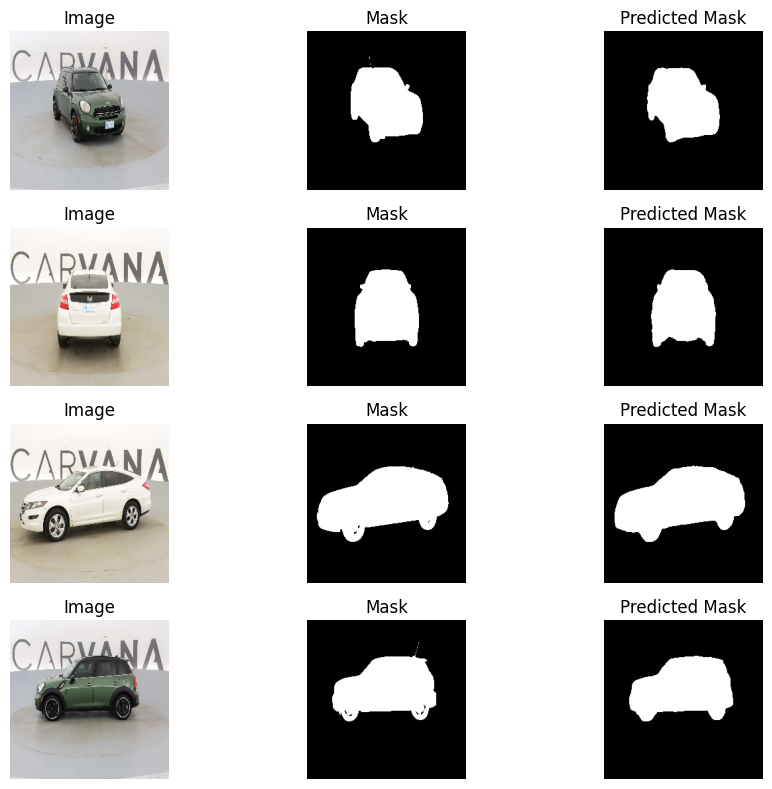

In [18]:
images, masks = next(iter(val_loader))
show_images_masks(images, masks, model = model, predict = True, num_examples=4)